In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn import tree
from sklearn import neighbors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic


from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn import linear_model
from sklearn import ensemble 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

#import xgboost as xgb

#from lightgbm import LGBMRegressor
#from autosklearn.regression import AutoSklearnRegressor
#from autosklearn.metrics import mean_absolute_error as auto_mean_absolute_error

#from numba import njit
#import shap


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
cwd = os.getcwd()

# Read and Scale the Data

In [4]:
train_data = pd.read_excel (r'data.xlsx') 

name=['Z','N','A']  #0.940609 1.02737  1.14384

x_train = pd.DataFrame(train_data,  columns=name)  
y_train = pd.DataFrame(train_data, columns= ['MeV'])

test_size = 0.70  # You can adjust this to set the proportion of the test set
random_state = 100  # You can choose any random_state value for reproducibility

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=random_state)

train_len=len(x_train)
test_len=len(x_test)

#test_data= pd.read_excel (r'test_fixed.xls')
#x_test = pd.DataFrame(test_data,  columns=name)  
#y_test = pd.DataFrame(test_data, columns= ['MeV'])

#test_len=len(x_test)

extra_data= pd.read_excel (r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data,  columns=name)  
y_extra = pd.DataFrame(extra_data, columns= ['MeV'])

inp=np.concatenate((x_train,x_test,x_extra),axis=0)
out=np.concatenate((y_train,y_test,y_extra),axis=0)
train_test_len=train_len+test_len

##################################
## scale
##################################
# Initialize the StandardScaler for input data
sc_X = StandardScaler()

# Fit the scaler on the training data
sc_X.fit(x_train)

# Transform the training and testing data using the fitted scaler
x_train = sc_X.transform(x_train)
x_test = sc_X.transform(x_test)
x_extra = sc_X.transform(x_extra)

# Initialize the StandardScaler for output data
sc_Y = StandardScaler()

# Fit the scaler on the training data
sc_Y.fit(y_train)

# Transform the training and testing data using the fitted scaler
y_train = sc_Y.transform(y_train)
y_test = sc_Y.transform(y_test)
y_extra = sc_Y.transform(y_extra)

# For input data
print("Input Data:")
print("Mean:", sc_X.mean_)
print("Standard Deviation:", sc_X.scale_)

# For output data
print("\nOutput Data:")
print("Mean:", sc_Y.mean_)
print("Standard Deviation:", sc_Y.scale_)
################################
name+=['original','prediction']


Input Data:
Mean: [ 56.71328671  79.04755245 135.76083916]
Standard Deviation: [24.70939415 38.28400282 62.61852653]

Output Data:
Mean: [-40.76148206]
Standard Deviation: [42.44917003]


In [5]:
print(x_train)

[[ 0.05207385  0.20772247  0.14754676]
 [-0.31216009 -0.60201522 -0.49124182]
 [ 0.98289392  1.30478644  1.18557821]
 ...
 [-1.68815498 -1.54235576 -1.60912185]
 [-0.75733491 -0.62813579 -0.6828784 ]
 [ 1.34712786  1.72271557  1.58482108]]


In [6]:
print(x_test)

[[ 0.94242348  0.75625445  0.83424449]
 [-0.27168965  0.02487847 -0.09199896]
 [ 0.86148261  0.36444589  0.56275934]
 ...
 [-1.08109841 -1.07218549 -1.08212127]
 [-0.1098079   0.20772247  0.0836679 ]
 [-1.48580279 -1.38563234 -1.43345499]]


In [7]:
print(x_extra)

[[-1.97144804 -1.85580261 -1.91254643]
 [-1.97144804 -1.82968204 -1.89657671]
 [-1.97144804 -1.80356147 -1.880607  ]
 ...
 [ 2.0351253   1.9578007   2.00003366]
 [ 2.0351253   1.98392127  2.01600338]
 [ 2.11606618  2.03616241  2.07988223]]


# Linear Models

## 3) [Gaussian Process](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)
### parameters: Scale: [1.0], Alpha: [1𝑒−09], Normalize: [False]
### Kernel selected as RBF + White

In [8]:
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-09] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)
            

R^2 Score: 0.9995548072365624
0.895660149078173 1.070580389922892 nan


### Result Explaanation
1. "R^2 Score: 0.9995548072360587" present the correlation between the predicted dependent variable and actual data. It is close to 1, which is a great result,  explaining almost all the variance of the dependent variable.
2. "0.021046297976098784 0.025156588574804902 nan" are the RMSE:
        RMSE error of training data predictions with respect to experimental data.
        Second one: RMSE error of test data predictions with respect to experimental data.
        The last one: We do not use this. It is trying to reach information in the "NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx", but in this file there is no experimental data and gives nan.


Column names: Index(['Z', 'N', 'A', 'A^2/3', '(N-Z)/A', 'PF', 'Zeo', 'NEO', 'Delta_Z',
       'Delta_N', 'Shell_P', 'Shell_N', 'prediction', 'Standard Deviation'],
      dtype='object')
Filtered data (Z=50):
         Z      N      A      A^2/3   (N-Z)/A   PF  Zeo  NEO  Delta_Z  \
2411  50.0   42.0   92.0  20.379423 -0.086957  0.0    0    0        0   
2412  50.0   43.0   93.0  20.526834 -0.075269  0.0    0    1        0   
2413  50.0   44.0   94.0  20.673717 -0.063830  0.0    0    0        0   
2414  50.0   45.0   95.0  20.820080 -0.052632  0.0    0    1        0   
2415  50.0   46.0   96.0  20.965931 -0.041667  0.0    0    0        0   
...    ...    ...    ...        ...       ...  ...  ...  ...      ...   
2493  50.0  124.0  174.0  31.167323  0.425287  0.0    0    0        0   
2494  50.0  125.0  175.0  31.286624  0.428571  0.0    0    1        0   
2495  50.0  126.0  176.0  31.405698  0.431818  0.0    0    0        0   
2496  50.0  127.0  177.0  31.524546  0.435028  0.0    0    1  

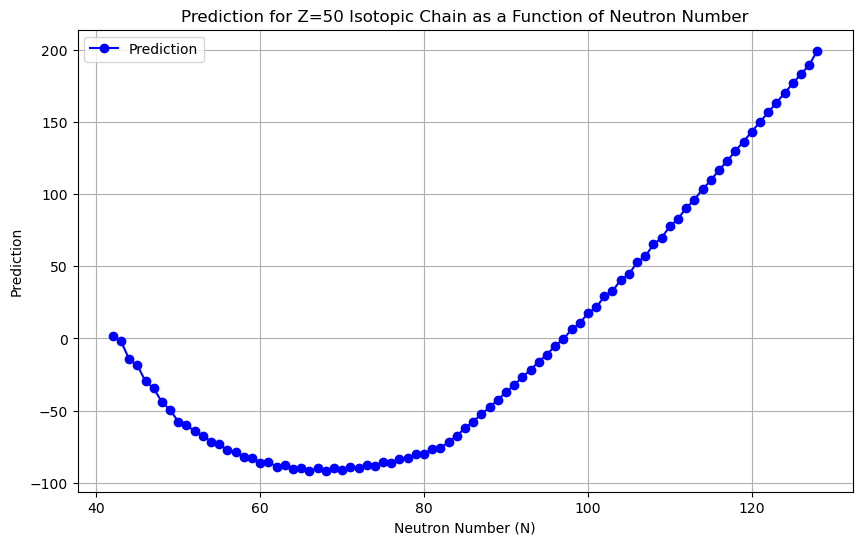

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'python_plot/extrapolation_with_std.xlsx'  # Update this with the actual path to your file
df = pd.read_excel(file_path)

# Check the column names to ensure they are correct
print("Column names:", df.columns)

# Filter the data for Z=50
df_Z50 = df[df['Z'] == 50]

# Check the filtered data
print("Filtered data (Z=50):")
print(df_Z50)

# Convert columns to numpy arrays before plotting
N_values = df_Z50['N'].values
prediction_values = df_Z50['prediction'].values

# Plot the prediction as a function of neutron number
plt.figure(figsize=(10, 6))
plt.plot(N_values, prediction_values, marker='o', linestyle='-', color='b', label='Prediction')

# Adding titles and labels
plt.title('Prediction for Z=50 Isotopic Chain as a Function of Neutron Number')
plt.xlabel('Neutron Number (N)')
plt.ylabel('Prediction')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# Overfitting Check
## Cross-validation

In [19]:
from sklearn.model_selection import cross_val_score

# Define the kernel
kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(gpr, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

# Print cross-validation results
print("Cross-Validation RMSE scores:", cv_rmse)
print("Mean Cross-Validation RMSE:", np.mean(cv_rmse))

# Fit the model on the entire training set
gpr.fit(x_train, y_train)

# Calculate the R^2 score for training and test data
r2_train = gpr.score(x_train, y_train)
r2_test = gpr.score(x_test, y_test)
print("R^2 Score (Train):", r2_train)
print("R^2 Score (Test):", r2_test)

# Check for overfitting
if (r2_train - r2_test) > 0.1 or (np.mean(cv_rmse) - rmse_train) > 0.1:
    print("Warning: The model might be overfitting. Consider regularization or using more training data.")

Cross-Validation RMSE scores: [0.03305856 0.02686774 0.02444195 0.02814338 0.07410807]
Mean Cross-Validation RMSE: 0.037323942187255536
R^2 Score (Train): 0.9995548072365624
R^2 Score (Test): 0.9993383545998773


## Conclusion of CV

The cross-validation RMSE scores show consistent performance across different subsets of the training data, with a mean RMSE of 0.037. The high \( R^2 \) scores for both the training set (0.9996) and the test set (0.9993) indicate that the model explains nearly all the variability in the data. These results suggest that the model is not significantly overfitting and generalizes well to unseen data.

## Learning Curve

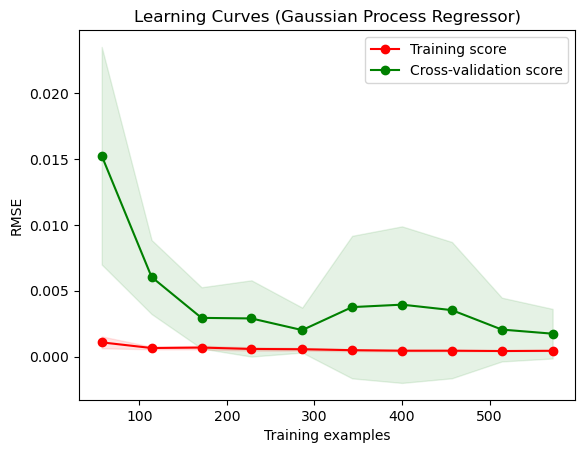

In [22]:
from sklearn.model_selection import learning_curve

kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

# Generate learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    gpr, x_train, y_train.ravel(), train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot learning curves
plt.figure()
plt.title('Learning Curves (Gaussian Process Regressor)')
plt.xlabel('Training examples')
plt.ylabel('RMSE')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

## Conclusion of Learning Curve
The learning curves indicate that the model performs very well on the training data, with a consistently low RMSE. However, there is a noticeable gap between the training and validation RMSE values, with the validation RMSE being higher. This suggests some degree of overfitting, as the model fits the training data better than it generalizes to unseen data. To address this, consider adding regularization, gathering more training data, simplifying the model, and using cross-validation to improve generalization.

There is some overfitting.